In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, log_loss
import xgboost as xgb
from collections import defaultdict
import warnings
from tqdm import tqdm
import time
warnings.filterwarnings('ignore')

In [2]:
class BreastCancerGeneAnalysis:
    def __init__(self, data):
        self.data = data
        self.models = {}
        self.results = defaultdict(dict)
        self.feature_importance = {}
        self.training_history = {}
        
    def prepare_data(self, test_size=0.2, val_size=0.2, random_state=42):
        print("Starting data preparation...")
        start_time = time.time()
        
        with tqdm(total=4, desc="Data Preparation") as pbar:
            X = self.data.drop(['sample_num', 'label'], axis=1)
            y = self.data['label']
            pbar.update(1)
            
            print(f"Dataset shape: {X.shape}")
            print(f"Class distribution:")
            print(f"Normal (0): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")
            print(f"Cancer (1): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")
            
            X_temp, self.X_test, y_temp, self.y_test = train_test_split(
                X, y, test_size=test_size, stratify=y, random_state=random_state
            )
            pbar.update(1)
            
            val_size_adjusted = val_size / (1 - test_size)
            self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
                X_temp, y_temp, test_size=val_size_adjusted, stratify=y_temp, random_state=random_state
            )
            pbar.update(1)
            
            print(f"\nDataset split results:")
            print(f"Training set: {self.X_train.shape[0]} samples")
            print(f"Validation set: {self.X_val.shape[0]} samples")
            print(f"Test set: {self.X_test.shape[0]} samples")
            
            self.scaler = StandardScaler()
            self.X_train_scaled = self.scaler.fit_transform(self.X_train)
            self.X_val_scaled = self.scaler.transform(self.X_val)
            self.X_test_scaled = self.scaler.transform(self.X_test)
            pbar.update(1)
        
        elapsed_time = time.time() - start_time
        print(f"Data preparation completed in {elapsed_time:.2f} seconds")
        return self
    
    def feature_selection(self, k_features=100):
        """
        Feature selection: use statistical methods to select the most important features
        """
        print(f"\n Starting feature selection for top {k_features} features...")
        start_time = time.time()
        
        with tqdm(total=3, desc="Feature Selection") as pbar:
            selector = SelectKBest(score_func=f_classif, k=k_features)
            pbar.update(1)
            
            self.X_train_selected = selector.fit_transform(self.X_train_scaled, self.y_train)
            self.X_val_selected = selector.transform(self.X_val_scaled)
            self.X_test_selected = selector.transform(self.X_test_scaled)
            pbar.update(1)
            
            self.selected_features = self.X_train.columns[selector.get_support()].tolist()
            self.feature_selector = selector
            pbar.update(1)
        
        elapsed_time = time.time() - start_time
        print(f"Feature selection completed in {elapsed_time:.2f} seconds")
        print(f"Selected {len(self.selected_features)} features from {self.X_train.shape[1]} total features")
        
        return self
    
    def initialize_models(self):
        print("\nInitializing machine learning models...")
        start_time = time.time()
        
        with tqdm(total=5, desc="Model Initialization") as pbar:
            self.models = {}
            
            self.models['Random Forest'] = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            )
            pbar.update(1)
            
            self.models['Logistic Regression'] = LogisticRegression(
                max_iter=1000,
                random_state=42,
                solver='liblinear'
            )
            pbar.update(1)
            
            self.models['SVM'] = SVC(
                kernel='rbf',
                C=1.0,
                gamma='scale',
                probability=True,
                random_state=42
            )
            pbar.update(1)
            
            self.models['Gradient Boosting'] = GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                random_state=42
            )
            pbar.update(1)
            
            self.models['XGBoost'] = xgb.XGBClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                random_state=42,
                eval_metric='logloss'
            )
            pbar.update(1)
        
        elapsed_time = time.time() - start_time
        print(f"Model initialization completed in {elapsed_time:.2f} seconds")
        print(f"Initialized {len(self.models)} models: {list(self.models.keys())}")
        
        return self
    
    def calculate_loss(self, y_true, y_pred_proba):
        y_pred_proba = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)
        return log_loss(y_true, y_pred_proba)
    
    def train_and_evaluate(self):
        print(f"\n Starting model training and evaluation...")
        overall_start = time.time()
        
        with tqdm(total=len(self.models), desc="Training Models") as pbar:
            for name, model in self.models.items():
                model_start = time.time()
                pbar.set_description(f"Training {name}")
                
                # Train model
                if name in ['Gradient Boosting', 'XGBoost']:
                    if name == 'XGBoost':
                        model.fit(
                            self.X_train_selected, self.y_train,
                            eval_set=[(self.X_train_selected, self.y_train), 
                                     (self.X_val_selected, self.y_val)],
                            verbose=False
                        )
                        evals_result = model.evals_result()
                        self.training_history[name] = {
                            'train_loss': evals_result['validation_0']['logloss'],
                            'val_loss': evals_result['validation_1']['logloss']
                        }
                    else:
                        model.fit(self.X_train_selected, self.y_train)
                        train_losses = []
                        val_losses = []
                        
                        for i, pred_proba in enumerate(model.staged_predict_proba(self.X_train_selected)):
                            train_loss = self.calculate_loss(self.y_train, pred_proba[:, 1])
                            train_losses.append(train_loss)
                        
                        for i, pred_proba in enumerate(model.staged_predict_proba(self.X_val_selected)):
                            val_loss = self.calculate_loss(self.y_val, pred_proba[:, 1])
                            val_losses.append(val_loss)
                        
                        self.training_history[name] = {
                            'train_loss': train_losses,
                            'val_loss': val_losses
                        }
                else:
                    model.fit(self.X_train_selected, self.y_train)
                    
                    train_pred_proba = model.predict_proba(self.X_train_selected)[:, 1]
                    val_pred_proba = model.predict_proba(self.X_val_selected)[:, 1]
                    
                    train_loss = self.calculate_loss(self.y_train, train_pred_proba)
                    val_loss = self.calculate_loss(self.y_val, val_pred_proba)
                    
                    self.training_history[name] = {
                        'train_loss': [train_loss],
                        'val_loss': [val_loss]
                    }
                
                y_val_pred = model.predict(self.X_val_selected)
                y_val_pred_proba = model.predict_proba(self.X_val_selected)[:, 1]
                
                y_test_pred = model.predict(self.X_test_selected)
                y_test_pred_proba = model.predict_proba(self.X_test_selected)[:, 1]
                
                val_accuracy = accuracy_score(self.y_val, y_val_pred)
                val_auc = roc_auc_score(self.y_val, y_val_pred_proba)
                val_loss_final = self.calculate_loss(self.y_val, y_val_pred_proba)
                
                test_accuracy = accuracy_score(self.y_test, y_test_pred)
                test_auc = roc_auc_score(self.y_test, y_test_pred_proba)
                test_loss = self.calculate_loss(self.y_test, y_test_pred_proba)
                
                train_pred_proba_final = model.predict_proba(self.X_train_selected)[:, 1]
                train_loss_final = self.calculate_loss(self.y_train, train_pred_proba_final)
                
                self.results[name] = {
                    'val_accuracy': val_accuracy,
                    'val_auc': val_auc,
                    'val_loss': val_loss_final,
                    'test_accuracy': test_accuracy,
                    'test_auc': test_auc,
                    'test_loss': test_loss,
                    'train_loss': train_loss_final,
                    'y_test_pred_proba': y_test_pred_proba
                }
                
                model_time = time.time() - model_start
                print(f"\n{name} Results (Training time: {model_time:.2f}s):")
                print(f"  Train Loss: {train_loss_final:.4f}")
                print(f"  Val Loss: {val_loss_final:.4f}, Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}")
                print(f"  Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, AUC: {test_auc:.4f}")
                
                pbar.update(1)
        
        total_time = time.time() - overall_start
        print(f"\n All models trained and evaluated in {total_time:.2f} seconds")
        
        return self
    
    def extract_feature_importance(self, top_k=20):
        """
        Extract important features from each model
        """
        print(f"\n Extracting top {top_k} important features...")
        start_time = time.time()
        
        with tqdm(total=len(self.models), desc="Feature Importance") as pbar:
            for name, model in self.models.items():
                pbar.set_description(f"Analyzing {name}")
                
                if name == 'Random Forest':
                    importance = model.feature_importances_
                elif name == 'Logistic Regression':
                    importance = np.abs(model.coef_[0])
                elif name == 'Gradient Boosting':
                    importance = model.feature_importances_
                elif name == 'XGBoost':
                    importance = model.feature_importances_
                elif name == 'SVM':
                    rfe = RFE(estimator=SVC(kernel='linear', random_state=42), n_features_to_select=top_k)
                    rfe.fit(self.X_train_selected, self.y_train)
                    importance = rfe.ranking_
                    importance = 1.0 / importance
                
                feature_names = self.selected_features
                feature_importance_pairs = list(zip(feature_names, importance))
                feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
                
                self.feature_importance[name] = feature_importance_pairs[:top_k]
                
                pbar.update(1)
        
        elapsed_time = time.time() - start_time
        print(f" Feature importance extraction completed in {elapsed_time:.2f} seconds")
        
        for name in self.models.keys():
            print(f"\n{name} - Top 5 Important Features:")
            for i, (feature, score) in enumerate(self.feature_importance[name][:5]):
                print(f"  {i+1}. {feature}: {score:.4f}")

        return self
    
    def plot_training_history(self):

        print("\n Plotting training history...")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, (name, history) in enumerate(self.training_history.items()):
            if i >= len(axes):
                break
            
            train_losses = history['train_loss']
            val_losses = history['val_loss']
            
            if len(train_losses) > 1: 
                epochs = range(1, len(train_losses) + 1)
                axes[i].plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
                axes[i].plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
                axes[i].set_xlabel('Epoch/Iteration')
            else: 
                axes[i].bar(['Train', 'Validation'], [train_losses[0], val_losses[0]], 
                           color=['blue', 'red'], alpha=0.7)
                axes[i].set_xlabel('Dataset')
            
            axes[i].set_ylabel('Log Loss')
            axes[i].set_title(f'{name}\nTraining vs Validation Loss')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        for j in range(len(self.training_history), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        return self
    
    def plot_model_comparison(self):
     
        print("\n Creating model comparison visualizations...")
        
        models = list(self.results.keys())
        val_accuracies = [self.results[model]['val_accuracy'] for model in models]
        test_accuracies = [self.results[model]['test_accuracy'] for model in models]
        val_aucs = [self.results[model]['val_auc'] for model in models]
        test_aucs = [self.results[model]['test_auc'] for model in models]
        train_losses = [self.results[model]['train_loss'] for model in models]
        val_losses = [self.results[model]['val_loss'] for model in models]
        
        fig = plt.figure(figsize=(20, 15))
        
        ax1 = plt.subplot(2, 3, 1)
        x = np.arange(len(models))
        width = 0.35
        
        ax1.bar(x - width/2, val_accuracies, width, label='Validation', alpha=0.8, color='skyblue')
        ax1.bar(x + width/2, test_accuracies, width, label='Test', alpha=0.8, color='lightcoral')
        ax1.set_xlabel('Models')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Model Accuracy Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        for i, (val_acc, test_acc) in enumerate(zip(val_accuracies, test_accuracies)):
            ax1.text(i - width/2, val_acc + 0.005, f'{val_acc:.3f}', 
                    ha='center', va='bottom', fontsize=9)
            ax1.text(i + width/2, test_acc + 0.005, f'{test_acc:.3f}', 
                    ha='center', va='bottom', fontsize=9)
        
        ax2 = plt.subplot(2, 3, 2)
        ax2.bar(x - width/2, val_aucs, width, label='Validation', alpha=0.8, color='lightgreen')
        ax2.bar(x + width/2, test_aucs, width, label='Test', alpha=0.8, color='orange')
        ax2.set_xlabel('Models')
        ax2.set_ylabel('AUC')
        ax2.set_title('Model AUC Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels(models, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        for i, (val_auc, test_auc) in enumerate(zip(val_aucs, test_aucs)):
            ax2.text(i - width/2, val_auc + 0.005, f'{val_auc:.3f}', 
                    ha='center', va='bottom', fontsize=9)
            ax2.text(i + width/2, test_auc + 0.005, f'{test_auc:.3f}', 
                    ha='center', va='bottom', fontsize=9)
        
        ax3 = plt.subplot(2, 3, 3)
        ax3.bar(x - width/2, train_losses, width, label='Training', alpha=0.8, color='purple')
        ax3.bar(x + width/2, val_losses, width, label='Validation', alpha=0.8, color='pink')
        ax3.set_xlabel('Models')
        ax3.set_ylabel('Log Loss')
        ax3.set_title('Model Loss Comparison')
        ax3.set_xticks(x)
        ax3.set_xticklabels(models, rotation=45, ha='right')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
            ax3.text(i - width/2, train_loss + 0.01, f'{train_loss:.3f}', 
                    ha='center', va='bottom', fontsize=9)
            ax3.text(i + width/2, val_loss + 0.01, f'{val_loss:.3f}', 
                    ha='center', va='bottom', fontsize=9)
        
        ax4 = plt.subplot(2, 3, 4)
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        for i, (name, color) in enumerate(zip(models, colors)):
            fpr, tpr, _ = roc_curve(self.y_test, self.results[name]['y_test_pred_proba'])
            auc_score = self.results[name]['test_auc']
            ax4.plot(fpr, tpr, color=color, lw=2, 
                    label=f'{name} (AUC = {auc_score:.3f})')
        
        ax4.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.8)
        ax4.set_xlim([0.0, 1.0])
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('False Positive Rate')
        ax4.set_ylabel('True Positive Rate')
        ax4.set_title('ROC Curves Comparison')
        ax4.legend(loc="lower right")
        ax4.grid(True, alpha=0.3)
        
        categories = ['Val Accuracy', 'Test Accuracy', 'Val AUC', 'Test AUC']
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1] 
        
        ax5 = plt.subplot(2, 3, 5, projection='polar')
        
        for i, (name, color) in enumerate(zip(models, colors)):
            values = [
                self.results[name]['val_accuracy'],
                self.results[name]['test_accuracy'],
                self.results[name]['val_auc'],
                self.results[name]['test_auc']
            ]
            values += values[:1] 
            
            ax5.plot(angles, values, 'o-', linewidth=2, label=name, color=color)
            ax5.fill(angles, values, alpha=0.25, color=color)
        
        ax5.set_xticks(angles[:-1])
        ax5.set_xticklabels(categories)
        ax5.set_ylim(0, 1)
        ax5.set_title('Comprehensive Performance Comparison', y=1.08)
        ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax5.grid(True)
        
        ax6 = plt.subplot(2, 3, 6)
        ax6.axis('tight')
        ax6.axis('off')
        
        table_data = []
        headers = ['Model', 'Train Loss', 'Val Loss', 'Val ACC', 'Test ACC', 'Test AUC']
        
        for name in models:
            row = [
                name,
                f"{self.results[name]['train_loss']:.4f}",
                f"{self.results[name]['val_loss']:.4f}",
                f"{self.results[name]['val_accuracy']:.4f}",
                f"{self.results[name]['test_accuracy']:.4f}",
                f"{self.results[name]['test_auc']:.4f}"
            ]
            table_data.append(row)
        
        table = ax6.table(cellText=table_data, colLabels=headers, 
                         cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        ax6.set_title('Performance Summary Table', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        return self
    
    def plot_feature_importance(self, top_k=10):

        print(f"\n Plotting top {top_k} feature importance...")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, (name, importance_list) in enumerate(self.feature_importance.items()):
            if i >= len(axes):
                break
                
            features = [item[0] for item in importance_list[:top_k]]
            scores = [item[1] for item in importance_list[:top_k]]
            
            y_pos = np.arange(len(features))
            axes[i].barh(y_pos, scores, alpha=0.8)
            axes[i].set_yticks(y_pos)
            axes[i].set_yticklabels([f.replace('ENSG', 'Gene') for f in features], fontsize=8)
            axes[i].set_xlabel('Importance Score')
            axes[i].set_title(f'{name}\nTop {top_k} Important Features')
            axes[i].grid(True, alpha=0.3)
            
            axes[i].invert_yaxis()
        
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        return self
    
    def generate_summary_report(self):
    
        print("\n" + "="*70)
        print("              BREAST CANCER GENE EXPRESSION ANALYSIS REPORT")
        print("="*70)
        
        print(f"\n DATASET INFORMATION:")
        print(f"• Total samples: {len(self.data)}")
        print(f"• Total genes: {self.X_train.shape[1]}")
        print(f"• Selected features: {len(self.selected_features)}")
        print(f"• Normal samples: {sum(self.data['label'] == 0)}")
        print(f"• Cancer samples: {sum(self.data['label'] == 1)}")
        
        print(f"\n MODEL PERFORMANCE RANKING (by Test AUC):")
        sorted_models = sorted(self.results.items(), 
                             key=lambda x: x[1]['test_auc'], reverse=True)
        
        for i, (name, metrics) in enumerate(sorted_models, 1):
            print(f"{i}. {name}:")
            print(f"   • Train Loss: {metrics['train_loss']:.4f}")
            print(f"   • Val Loss: {metrics['val_loss']:.4f}")
            print(f"   • Test Accuracy: {metrics['test_accuracy']:.4f}")
            print(f"   • Test AUC: {metrics['test_auc']:.4f}")
        
        best_model = sorted_models[0][0]
        best_metrics = sorted_models[0][1]
        print(f"\n BEST PERFORMING MODEL: {best_model}")
        print(f"• AUC Score: {best_metrics['test_auc']:.4f}")
        print(f"• Accuracy: {best_metrics['test_accuracy']:.4f}")
        print(f"• Training Loss: {best_metrics['train_loss']:.4f}")
        print(f"• Validation Loss: {best_metrics['val_loss']:.4f}")
        
        print(f"\n TOP IMPORTANT GENES (from {best_model}):")
        for i, (gene, score) in enumerate(self.feature_importance[best_model][:10], 1):
            print(f"{i:2d}. {gene}: {score:.4f}")
        
        print(f"\n PERFORMANCE SUMMARY:")
        print(f"• Highest Test AUC: {max([m['test_auc'] for m in self.results.values()]):.4f}")
        print(f"• Highest Test Accuracy: {max([m['test_accuracy'] for m in self.results.values()]):.4f}")
        print(f"• Lowest Validation Loss: {min([m['val_loss'] for m in self.results.values()]):.4f}")
        
        print("="*70)
        return self

In [3]:
def validate_data_format(df):
   
    print(" Validating data format...")
    
    required_columns = ['sample_num', 'label']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    unique_labels = df['label'].unique()
    if not all(label in [0, 1] for label in unique_labels):
        raise ValueError("Labels must be 0 (normal) or 1 (cancer)")
    
    gene_columns = [col for col in df.columns if col not in ['sample_num', 'label']]
    if len(gene_columns) < 10:
        raise ValueError("Dataset must have at least 10 gene expression columns")
    
    print(f" Data format validation passed")
    print(f"   • Samples: {len(df)}")
    print(f"   • Gene columns: {len(gene_columns)}")
    print(f"   • Class distribution: {df['label'].value_counts().to_dict()}")
    
    return True

In [4]:
def run_analysis(df):

    print(" Starting Breast Cancer Gene Expression Analysis Pipeline")
    print("="*70)
    
    pipeline_start = time.time()
    
    analyzer = BreastCancerGeneAnalysis(df)
    
    (analyzer
     .prepare_data(test_size=0.2, val_size=0.2)
     .feature_selection(k_features=100)  # Adjust feature count as needed
     .initialize_models()
     .train_and_evaluate()
     .extract_feature_importance(top_k=20)
     .plot_training_history()
     .plot_model_comparison()
     .plot_feature_importance(top_k=10)
     .generate_summary_report())
    
    total_time = time.time() - pipeline_start
    print(f"\n ANALYSIS PIPELINE COMPLETED SUCCESSFULLY!")
    print(f" Total execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print("="*70)
    
    return analyzer

In [5]:
def save_results(analyzer, output_dir="results"):
   
    import os
    import pickle
    
    print(f"\n💾 Saving results to {output_dir}/...")
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    results_df = pd.DataFrame(analyzer.results).T
    results_df.to_csv(f"{output_dir}/model_performance.csv")
    
    for model_name, features in analyzer.feature_importance.items():
        feature_df = pd.DataFrame(features, columns=['Gene', 'Importance'])
        feature_df.to_csv(f"{output_dir}/feature_importance_{model_name.replace(' ', '_')}.csv", index=False)
    
    with open(f"{output_dir}/analyzer.pkl", 'wb') as f:
        pickle.dump(analyzer, f)
    
    print("✅ Results saved successfully!")
    print(f"   • Model performance: {output_dir}/model_performance.csv")
    print(f"   • Feature importance: {output_dir}/feature_importance_*.csv")
    print(f"   • Complete analyzer: {output_dir}/analyzer.pkl")


In [6]:
df = pd.read_csv('combined_data.csv')

In [7]:
validate_data_format(df)

 Validating data format...
 Data format validation passed
   • Samples: 289
   • Gene columns: 60675
   • Class distribution: {1: 179, 0: 110}


True

 Starting Breast Cancer Gene Expression Analysis Pipeline
Starting data preparation...


Data Preparation:  50%|█████     | 2/4 [00:00<00:00, 16.39it/s]

Dataset shape: (289, 60675)
Class distribution:
Normal (0): 110 (38.1%)
Cancer (1): 179 (61.9%)

Dataset split results:
Training set: 173 samples
Validation set: 58 samples
Test set: 58 samples


Data Preparation: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Data preparation completed in 1.47 seconds

 Starting feature selection for top 100 features...


Feature Selection: 100%|██████████| 3/3 [00:00<00:00, 10.34it/s]


Feature selection completed in 0.29 seconds
Selected 100 features from 60675 total features

Initializing machine learning models...


Model Initialization: 100%|██████████| 5/5 [00:00<00:00, 4983.73it/s]


Model initialization completed in 0.00 seconds
Initialized 5 models: ['Random Forest', 'Logistic Regression', 'SVM', 'Gradient Boosting', 'XGBoost']

 Starting model training and evaluation...


Training Gradient Boosting:  60%|██████    | 3/5 [00:00<00:00,  3.17it/s]  


Random Forest Results (Training time: 0.32s):
  Train Loss: 0.1182
  Val Loss: 0.3573, Accuracy: 0.8103, AUC: 0.9217
  Test Loss: 0.3896, Accuracy: 0.8103, AUC: 0.9003

Logistic Regression Results (Training time: 0.02s):
  Train Loss: 0.0383
  Val Loss: 0.6126, Accuracy: 0.8621, AUC: 0.9053
  Test Loss: 0.5766, Accuracy: 0.8103, AUC: 0.9104

SVM Results (Training time: 0.03s):
  Train Loss: 0.1039
  Val Loss: 0.4417, Accuracy: 0.8276, AUC: 0.8889
  Test Loss: 0.3819, Accuracy: 0.8448, AUC: 0.9104


Training XGBoost: 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]          



Gradient Boosting Results (Training time: 0.84s):
  Train Loss: 0.0000
  Val Loss: 1.4152, Accuracy: 0.8103, AUC: 0.8523
  Test Loss: 1.8131, Accuracy: 0.7759, AUC: 0.8106

XGBoost Results (Training time: 0.13s):
  Train Loss: 0.0216
  Val Loss: 0.3558, Accuracy: 0.8103, AUC: 0.9230
  Test Loss: 0.3978, Accuracy: 0.7931, AUC: 0.9066

 All models trained and evaluated in 1.34 seconds

 Extracting top 20 important features...


Analyzing XGBoost: 100%|██████████| 5/5 [00:00<00:00, 18.38it/s]            


 Feature importance extraction completed in 0.27 seconds

Random Forest - Top 5 Important Features:
  1. ENSG00000201098: 0.0843
  2. ENSG00000202354: 0.0532
  3. ENSG00000183878: 0.0496
  4. ENSG00000114374: 0.0413
  5. ENSG00000252316: 0.0389

Logistic Regression - Top 5 Important Features:
  1. ENSG00000122335: 0.6901
  2. ENSG00000171100: 0.6807
  3. ENSG00000176619: 0.6733
  4. ENSG00000124126: 0.6712
  5. ENSG00000156313: 0.6654

SVM - Top 5 Important Features:
  1. ENSG00000009694: 1.0000
  2. ENSG00000012174: 1.0000
  3. ENSG00000072041: 1.0000
  4. ENSG00000101901: 1.0000
  5. ENSG00000101974: 1.0000

Gradient Boosting - Top 5 Important Features:
  1. ENSG00000183878: 0.3966
  2. ENSG00000201098: 0.2052
  3. ENSG00000176619: 0.0898
  4. ENSG00000105401: 0.0760
  5. ENSG00000179950: 0.0509

XGBoost - Top 5 Important Features:
  1. ENSG00000183878: 0.1183
  2. ENSG00000201098: 0.1181
  3. ENSG00000012817: 0.0583
  4. ENSG00000235649: 0.0513
  5. ENSG00000176619: 0.0343

 Plottin

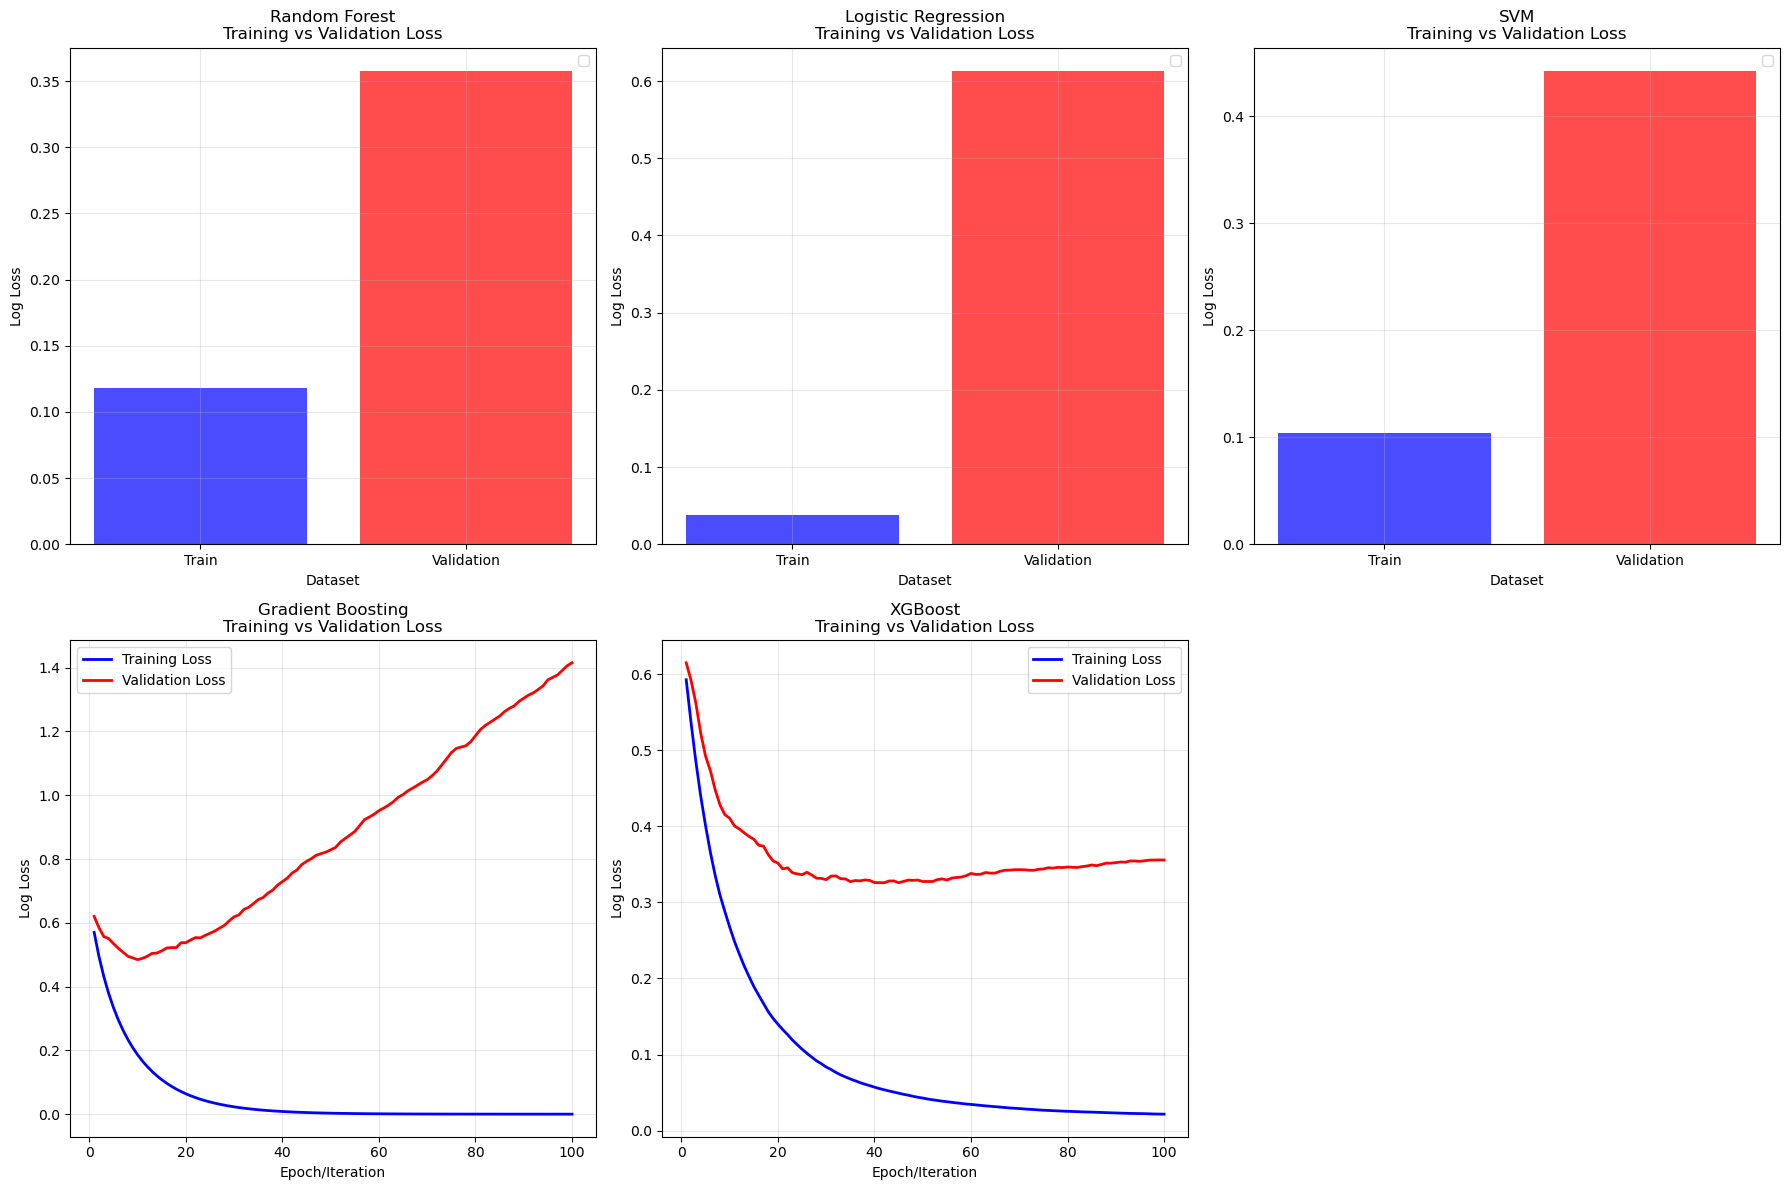


 Creating model comparison visualizations...


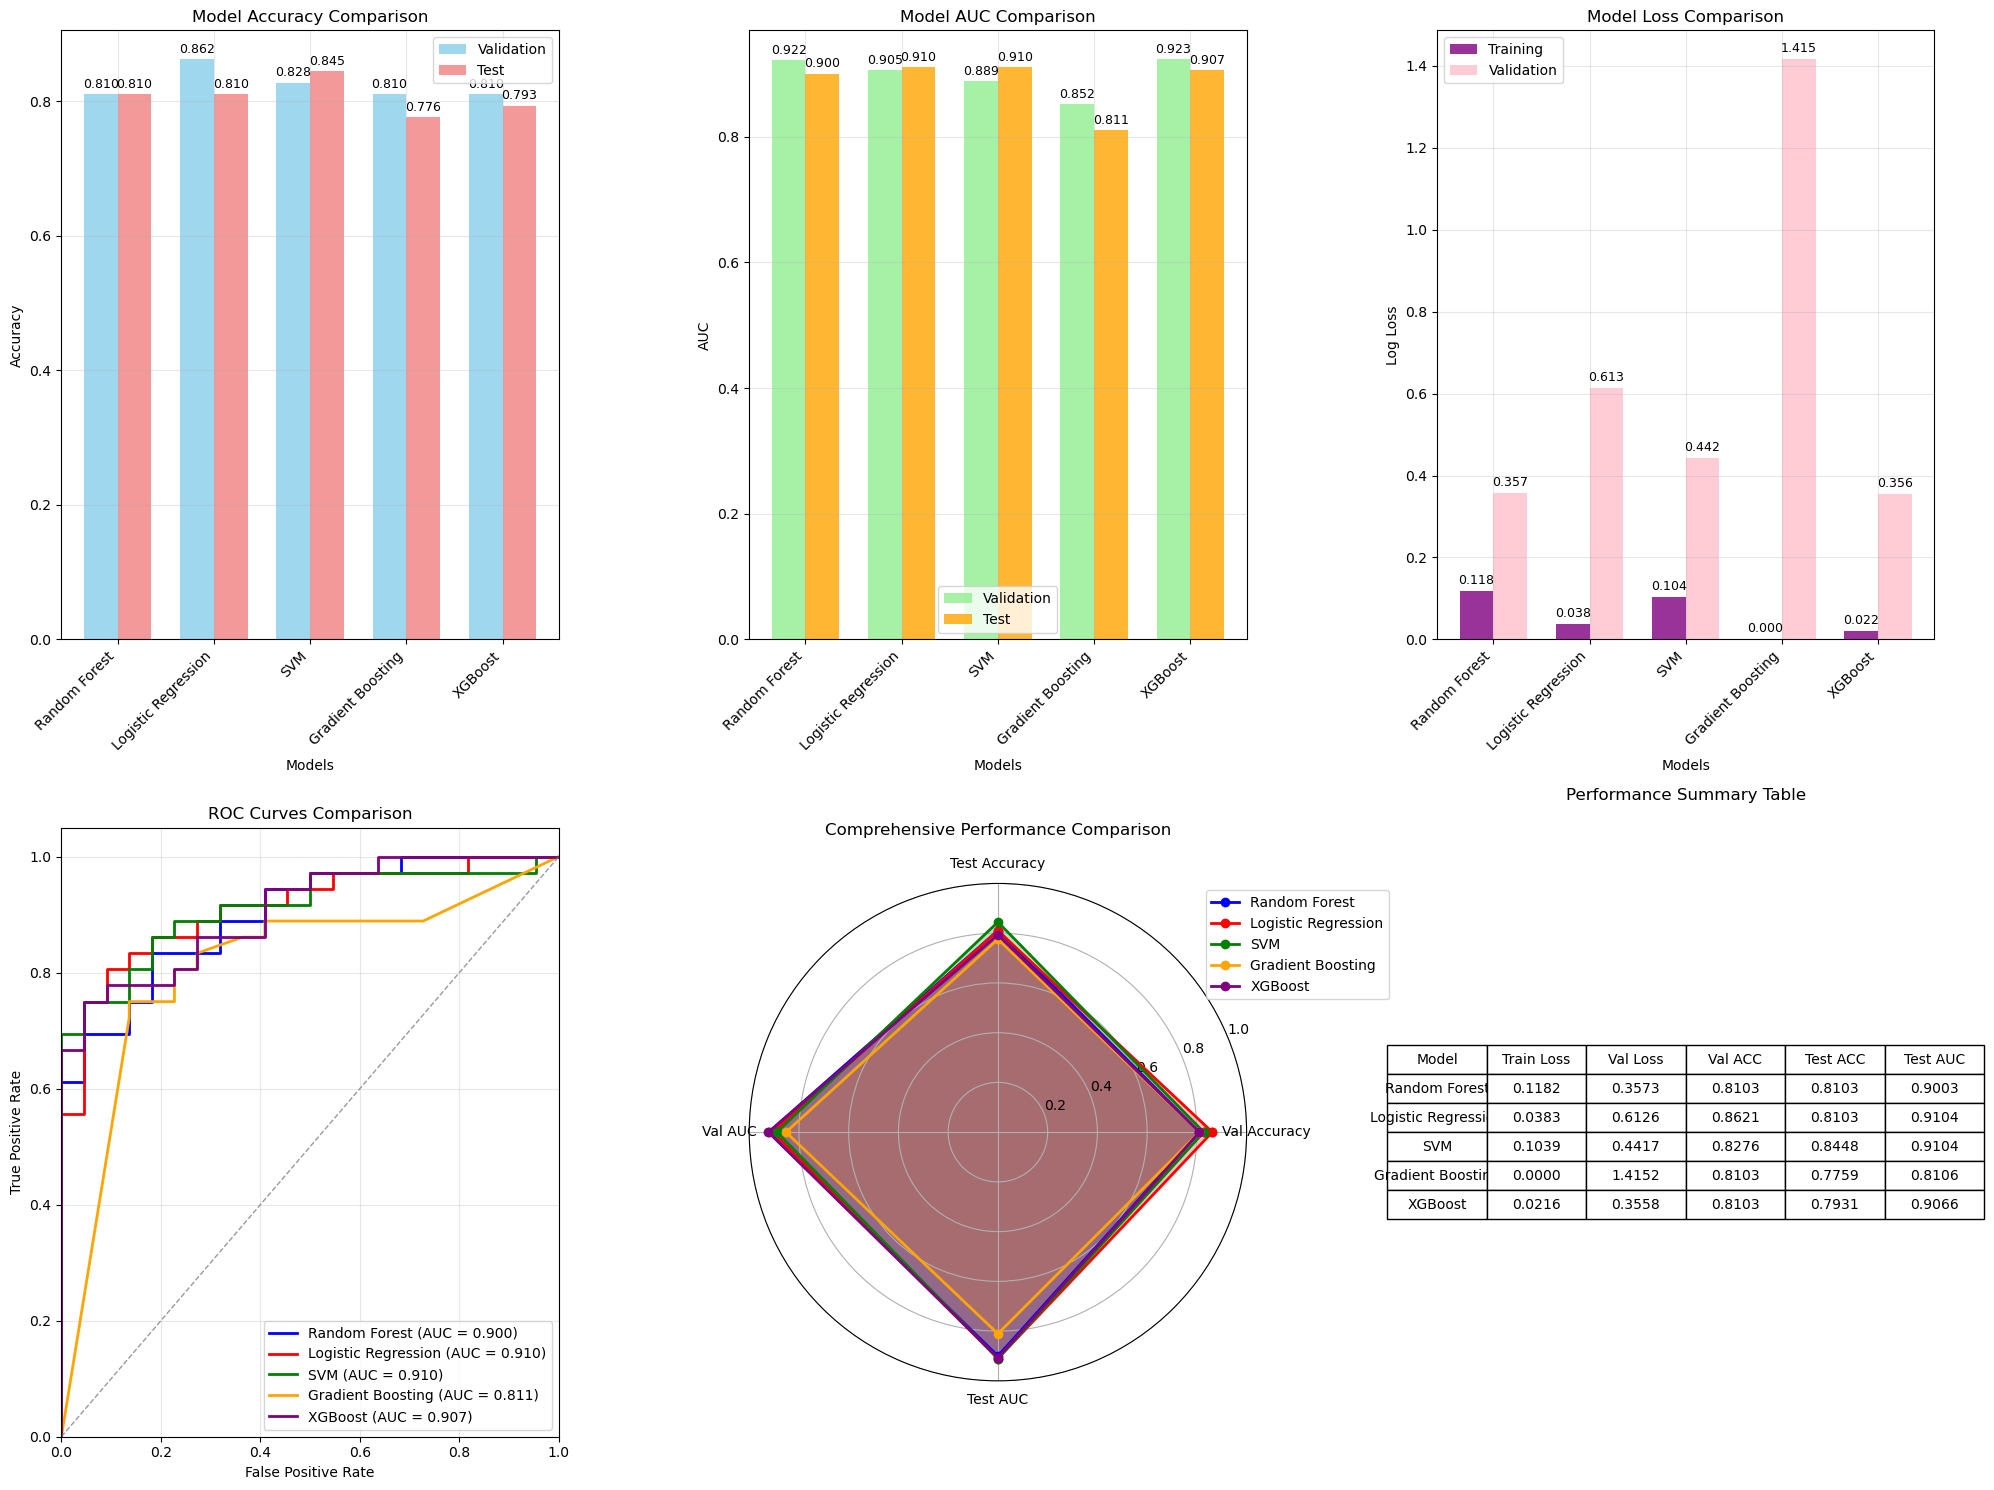


 Plotting top 10 feature importance...


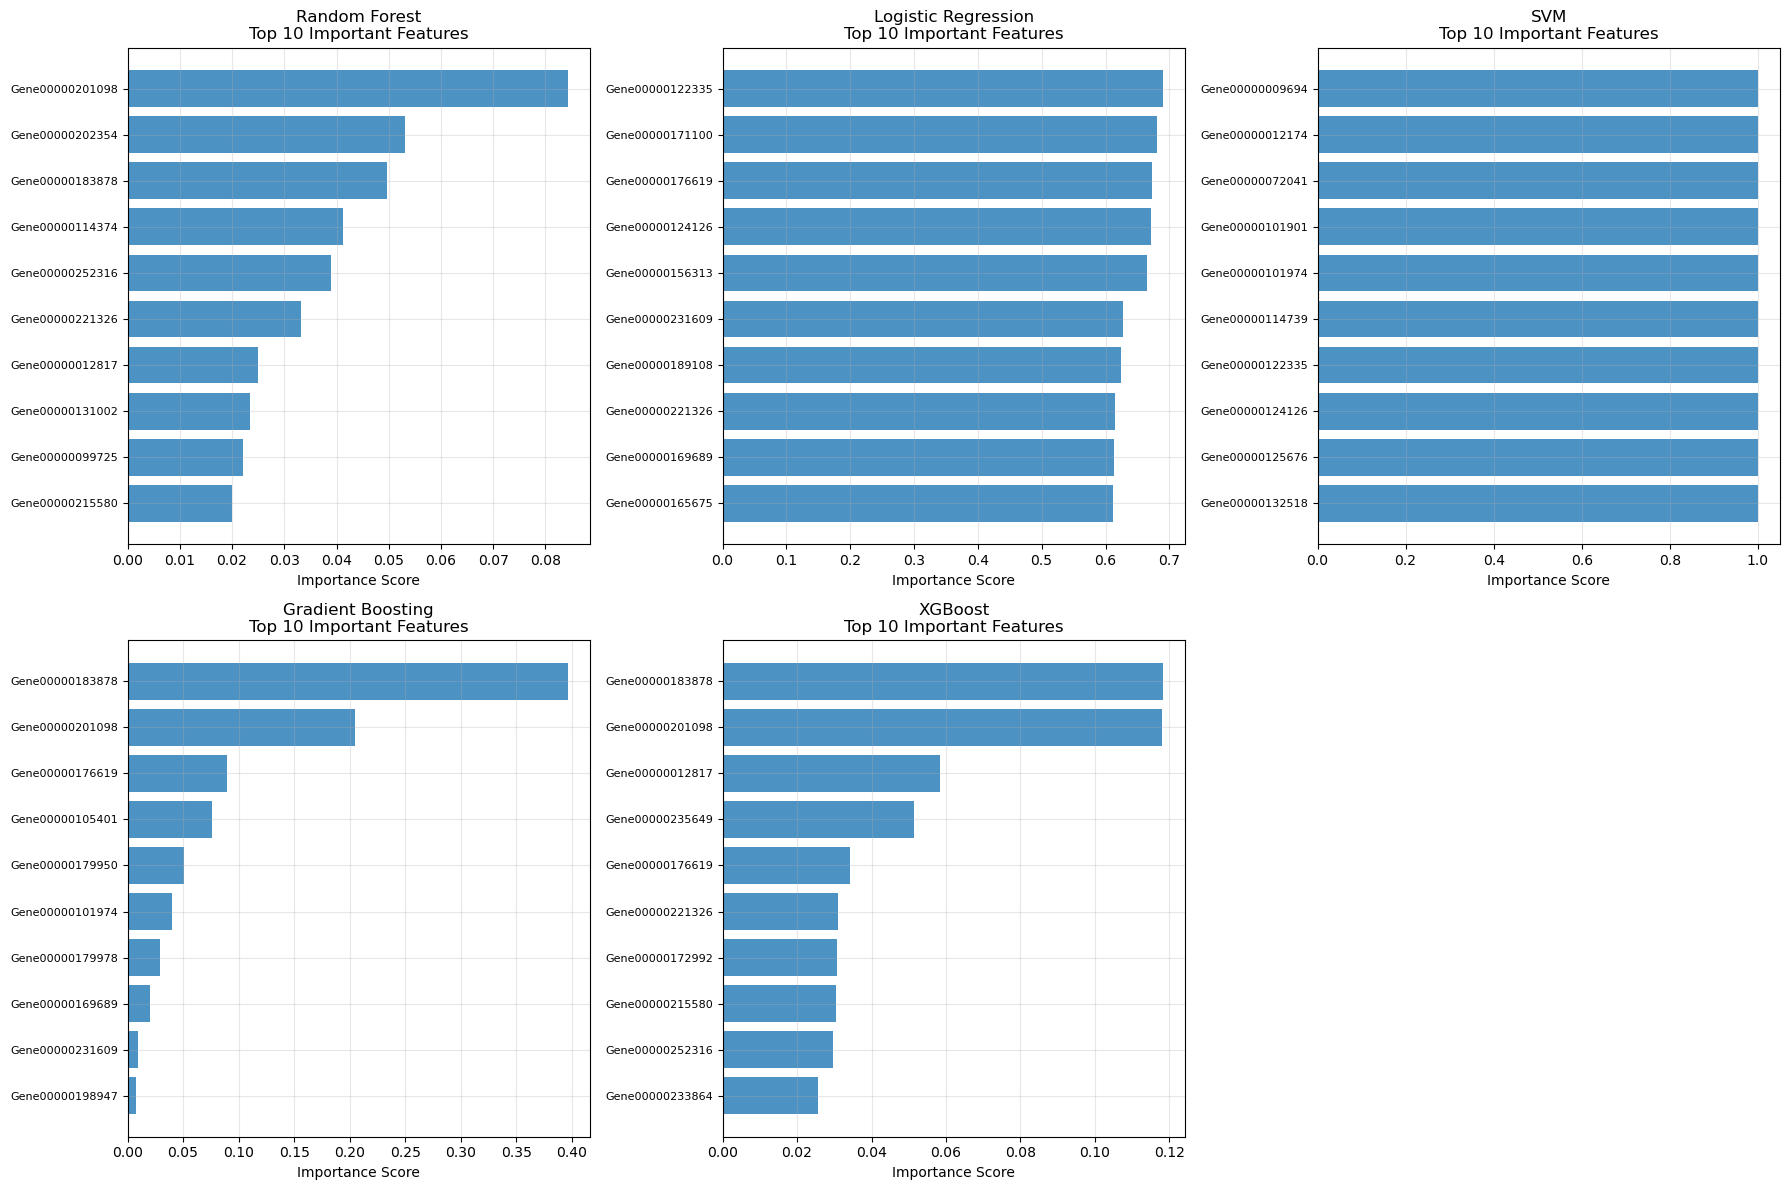


              BREAST CANCER GENE EXPRESSION ANALYSIS REPORT

 DATASET INFORMATION:
• Total samples: 289
• Total genes: 60675
• Selected features: 100
• Normal samples: 110
• Cancer samples: 179

 MODEL PERFORMANCE RANKING (by Test AUC):
1. Logistic Regression:
   • Train Loss: 0.0383
   • Val Loss: 0.6126
   • Test Accuracy: 0.8103
   • Test AUC: 0.9104
2. SVM:
   • Train Loss: 0.1039
   • Val Loss: 0.4417
   • Test Accuracy: 0.8448
   • Test AUC: 0.9104
3. XGBoost:
   • Train Loss: 0.0216
   • Val Loss: 0.3558
   • Test Accuracy: 0.7931
   • Test AUC: 0.9066
4. Random Forest:
   • Train Loss: 0.1182
   • Val Loss: 0.3573
   • Test Accuracy: 0.8103
   • Test AUC: 0.9003
5. Gradient Boosting:
   • Train Loss: 0.0000
   • Val Loss: 1.4152
   • Test Accuracy: 0.7759
   • Test AUC: 0.8106

 BEST PERFORMING MODEL: Logistic Regression
• AUC Score: 0.9104
• Accuracy: 0.8103
• Training Loss: 0.0383
• Validation Loss: 0.6126

 TOP IMPORTANT GENES (from Logistic Regression):
 1. ENSG00000122335

In [8]:
analyzer = run_analysis(df)
